# [모듈 3.7] 추론 및 결과 분석

이 노트북은 이전 노트북에서 생성한 앤드포인트를 대상으로 실제 추론을 하여, 평가 결과를 얻습니다. 테스트 데이터 세트는 1000개를 사용하여 결과를 확인 합니다.
- 0. 기본 세이지 메이커 정보 및 기본 변수 로딩
- 1. 테스트 데이터 세트 로딩
- 2. 추론할 Payload 생성
- 3. 추론 실행
- 4. 예측의 확률값을 0, 1로 변화하여 리포팅
- 5. 엔드포인트 삭제

---
### 노트북 커널
- 이 워크샵은 노트북 커널이 `conda_python3` 를 사용합니다. 다른 커널일 경우 변경 해주세요.
---



## 0. 기본 세이지 메이커 정보 및 기본 변수 로딩

In [1]:
import boto3
import sagemaker
import pandas as pd

region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

%store -r 


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [31]:
sagemaker.__version__

'2.227.0'

아래는 사용자 정의의 함수를 로딩 할때마다, 캐시에 있는 것보다는 원본을 로딩함.

In [2]:
%load_ext autoreload
%autoreload 2

## 1. 테스트 데이터 세트 로딩

In [17]:
import os
test_preproc_dir_artifact = r'opt/ml/processing/output/test'
test_preproc_dir_artifact_file= os.path.join(test_preproc_dir_artifact, 'test.csv')
test_df = pd.read_csv(test_preproc_dir_artifact_file)
test_df.head()
test_df.tail()

,fraud,vehicle_claim,total_claim_amount,customer_age,months_as_customer,num_claims_past_year,num_insurers_past_5_years,policy_deductable,policy_annual_premium,customer_zip,...,collision_type_missing,incident_severity_Major,incident_severity_Minor,incident_severity_Totaled,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_Police,authorities_contacted_missing,police_report_available_No,police_report_available_Yes
995,1,1494.409549,17194.409549,33,4,0,3,750,2550,92028,...,0,0,1,0,0,0,0,1,1,0
996,0,14837.909976,49737.909976,45,150,0,1,750,3000,89178,...,0,0,1,0,0,0,0,1,1,0
997,0,12421.253027,24121.253027,28,87,0,1,750,2950,91702,...,0,0,1,0,0,0,0,1,1,0
998,0,10991.604997,24991.604997,21,5,0,2,750,3000,94103,...,0,0,1,0,0,0,1,0,0,1
999,1,11126.988621,14826.988621,66,298,0,1,750,2750,92869,...,0,0,1,0,0,0,0,1,1,0


## 2. 추론할 Payload 생성

- 추론에 입력될 CST String 형태의 데이터로 변경 (payload)

In [8]:
def get_payload_list(test_df, label_col):
    '''
    CSV String 행태로 변경
    '''
    s = test_df.drop(columns=[label_col])
    s = s.to_csv(header=None, index=None)
    payload_list = s.splitlines()
    return payload_list

payload_list = get_payload_list(test_df, label_col='fraud')
y_test = test_df['fraud'].tolist()

print("payload_list: \n", payload_list[0:1]) # 샘플로 5개의 리스트 보여줌.


payload_list: 
 ['23901.43250714285,36201.43250714285,56,118,0,1,750,3000,98039,2012,3,3,1,12300,9,12,3,14,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1']


In [30]:
payload = payload_list[0]
payload_len_list = []
print('original test_df shape: ', test_df.shape)
print(f"payload_list type: {type(payload_list)}, payload_list length: {len(payload_list)}")
print(f"payload type: {type(payload)}, payload length: {len(payload)}")
for payload in payload_list:
    if not len(payload_len_list)==0:
        if len(payload) in payload_len_list:
            continue
    payload_len_list.append(len(payload))
print(payload_len_list)

original test_df shape:  (1000, 59)
payload_list type: <class 'list'>, payload_list length: 1000
payload type: <class 'str'>, payload length: 168
[168, 167, 169, 166, 170, 165, 164, 145, 147, 146, 171, 142, 163, 162]


In [33]:
for payload in payload_list[:5]:
    print(payload)

23901.43250714285,36201.43250714285,56,118,0,1,750,3000,98039,2012,3,3,1,12300,9,12,3,14,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1
29095.295735759966,73695.29573575997,36,71,0,1,750,2650,95307,2016,3,1,1,44600,8,8,3,17,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1
11232.831825505647,25032.831825505647,24,11,1,4,750,3000,98391,2016,2,0,2,13800,2,11,0,21,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0
11125.579356093212,25125.57935609321,23,65,0,1,750,3000,91302,2015,2,0,0,14000,8,7,2,7,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0
4529.773913037943,22329.77391303794,37,142,0,1,750,3000,90744,2008,2,0,1,17800,4,2,1,13,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0


## 3. 추론 실행
- 앤드포인트가 InServie로 유효하면 추론을 하여, 확률값을 제공함.
- 위에서 준비한 테스트 데이터 세트에서 실험적으로 5개의 샘플만을 추론을 함.

In [10]:
%%time

import numpy as np
import boto3
sagemaker_boto_client = boto3.client('sagemaker')

from sagemaker.deserializers import CSVDeserializer
csv_deserializer = CSVDeserializer(accept='text/csv') # 디폴트가 accept가 'text/csv' 이지만 직관적 이유로 기술함.

from src.p_utils import is_available_endpoint, get_predictor, get_payload, predict, delete_endpoint

all_pipeline_endpoint_name = "all-pipeline-endpoint-891581"

pipeline_predictor = get_predictor(all_pipeline_endpoint_name, sagemaker_session, csv_deserializer)
pred_prob_list = []
payload_list = get_payload_list(test_df, label_col='fraud')
for payload in payload_list:
    pred_prob = predict(pipeline_predictor, payload)
    pred_prob_list.append(float(pred_prob[0]))


print("pred_prob_list: \n", pred_prob_list[0:5])


pred_prob_list: 
 [0.10092484205961227, 0.08251918852329254, 0.5043554902076721, 0.23539546132087708, 0.669212281703949]
CPU times: user 998 ms, sys: 40.2 ms, total: 1.04 s
Wall time: 8 s


## 4. 예측의 확률값을 0, 1로 변화하여 리포팅
- threshold 값이 보다 작으면 0, 크면 1로 할당한후에, Confustion Matrix로 보여줌

In [11]:
import matplotlib.pyplot as plt
import itertools
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    plt.show()

#### 결과 해석

아래는 하나의 Confustion 행렬의 예로서, 해석의 방법은 아래와 같습니다.
- 전체 1000 개의 테스트 데이터 세트 이고, 이중에 33개 (7+26) 가 fraud 임. 
- 33개 중에서 26개를 잘 예측 했음 (fraud:1 에 대한 recall 이 0.79, 26/33). (True Positive, TP)
- 정상인 967 개 중에서 697개를 잘 예측 했음(fraud:0 에 대한 recall 이 0.72, 697/967). (True Negative, TN)
- 실제 fraud 이지만, 예측을 정상으로 한것이 7개 (False Negative, FN)
- 실제 정상이지만, fraud 로 예측한 것이 270개 (False Positive, FP)
    - 조금 더 상세한 의미는 인터넷에 많이 있습니다. 하나의 참조입니다.  --> [분류 성능 평가](https://datascienceschool.net/03%20machine%20learning/09.04%20분류%20성능평가.html) 

```
       legit fraud
legit   697   270
fraud     7    26
```

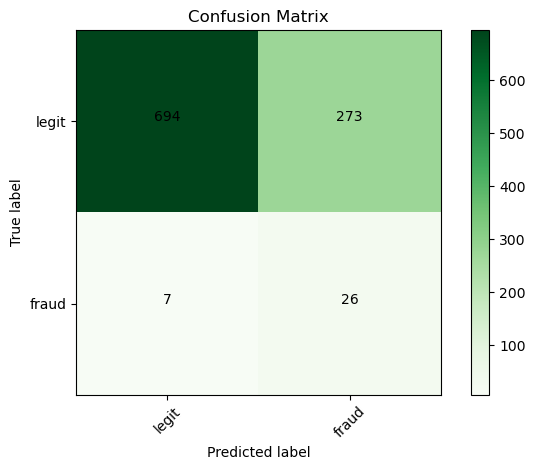

[[694 273]
 [  7  26]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       967
           1       0.09      0.79      0.16        33

    accuracy                           0.72      1000
   macro avg       0.54      0.75      0.49      1000
weighted avg       0.96      0.72      0.81      1000



In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

threshold = 0.5
predictions = [1 if e >= threshold else 0 for e in pred_prob_list ] 
    

cm = confusion_matrix(y_true= y_test, y_pred= predictions)    
plot_conf_mat(cm, classes=['legit','fraud'], 
                  title='Confusion Matrix')
print(cm)

print(f"{classification_report(y_true=y_test, y_pred = predictions)}")


## 5. 엔드포인트 삭제
- **[중요] 과금을 막기 위해서 아래 코드를 꼭 수행 바랍니다.**
- is_del_model= True  를 통해서 생성한 모델 및 이전 파이프라인을 통한 엔드포인트 컨피그 와  엔드포인트를 삭제 합니다.

In [ ]:
# import boto3
# boto3_client = boto3.client('sagemaker')
# delete_endpoint(boto3_client, all_pipeline_endpoint_name, is_del_model=True )

